In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
import seaborn as sns
from collections import Counter

In [2]:
# =============================================================================
# ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ MNIST
# =============================================================================

print("Загрузка данных MNIST...")
# Загружаем данные MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data.astype('float32')
y = mnist.target.astype('int32')

# Нормализуем данные (важно для PCA)
X = X / 255.0

print(f"Размерность данных: {X.shape}")
print(f"Размерность меток: {y.shape}")

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=10000, random_state=42, stratify=y_train
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Валидационная выборка: {X_val.shape}")
print(f"Тестовая выборка: {X_test.shape}")

Загрузка данных MNIST...
Размерность данных: (70000, 784)
Размерность меток: (70000,)
Обучающая выборка: (50000, 784)
Валидационная выборка: (10000, 784)
Тестовая выборка: (10000, 784)



Примеры цифр из датасета MNIST:


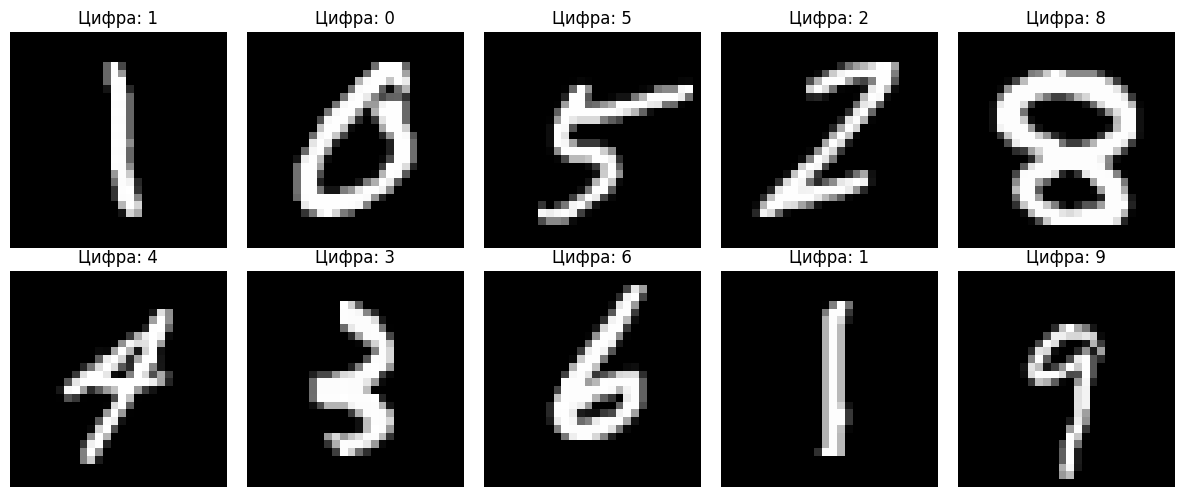

In [3]:
# =============================================================================
# ВИЗУАЛИЗАЦИЯ ДАННЫХ
# =============================================================================

def plot_mnist_samples(X, y, num_samples=10):
    """Визуализация случайных образцов из датасета MNIST"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    
    # Выбираем случайные индексы
    indices = np.random.choice(len(X), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        axes[i].imshow(X[idx].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'Цифра: {y[idx]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nПримеры цифр из датасета MNIST:")
plot_mnist_samples(X_train, y_train)


In [4]:
# =============================================================================
# РЕАЛИЗАЦИЯ PCA С НУЛЯ
# =============================================================================

class my_PCA:
    """
    Реализация метода главных компонент (PCA) с нуля
    """
    
    def __init__(self, n_components=None):
        """
        Инициализация PCA
        
        Parameters:
        n_components (int): Количество главных компонент для сохранения
        """
        self.n_components = n_components
        self.components = None      # Главные компоненты (собственные векторы)
        self.explained_variance = None  # Объясненная дисперсия
        self.mean = None            # Среднее значение для центрирования
        self.cumulative_variance = None  # Накопленная объясненная дисперсия
    
    def fit(self, X):
        """
        Обучение PCA на данных X
        
        Parameters:
        X (ndarray): Матрица признаков формы (n_samples, n_features)
        """
        # Шаг 1: Центрирование данных
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Шаг 2: Вычисление ковариационной матрицы
        cov_matrix = np.cov(X_centered, rowvar=False)
        
        # Шаг 3: Вычисление собственных векторов и значений
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Сортируем собственные значения и векторы по убыванию
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Сохраняем компоненты
        if self.n_components is not None:
            self.components = eigenvectors[:, :self.n_components]
        else:
            self.components = eigenvectors
        
        # Вычисляем объясненную дисперсию
        total_variance = np.sum(eigenvalues)
        self.explained_variance = eigenvalues / total_variance
        self.cumulative_variance = np.cumsum(self.explained_variance)
        
        return self
    
    def transform(self, X):
        """
        Преобразование данных в пространство главных компонент
        
        Parameters:
        X (ndarray): Матрица признаков формы (n_samples, n_features)
        
        Returns:
        ndarray: Преобразованные данные
        """
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)
    
    def fit_transform(self, X):
        """
        Обучение и преобразование данных за одну операцию
        """
        self.fit(X)
        return self.transform(X)

In [5]:
# =============================================================================
# РЕАЛИЗАЦИЯ kNN С НУЛЯ
# =============================================================================

class my_kNN:
    """
    Реализация алгоритма k-ближайших соседей (kNN) с нуля
    """
    
    def __init__(self, n_neighbors=5):
        """
        Инициализация kNN
        
        Parameters:
        n_neighbors (int): Количество ближайших соседей для классификации
        """
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """
        Обучение kNN (просто запоминаем данные)
        
        Parameters:
        X (ndarray): Обучающие данные
        y (ndarray): Метки классов
        """
        self.X_train = X
        self.y_train = y
        return self
    
    def predict(self, X):
        """
        Предсказание классов для новых данных
        
        Parameters:
        X (ndarray): Данные для классификации
        
        Returns:
        ndarray: Предсказанные метки классов
        """
        predictions = []
        for x in X:
            # Вычисляем расстояния до всех точек обучающей выборки
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            
            # Находим k ближайших соседей
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = self.y_train[nearest_indices]
            
            # Выбираем наиболее частый класс
            most_common = Counter(nearest_labels).most_common(1)[0][0]
            predictions.append(most_common)
        
        return np.array(predictions)



АНАЛИЗ МЕТОДА ГЛАВНЫХ КОМПОНЕНТ


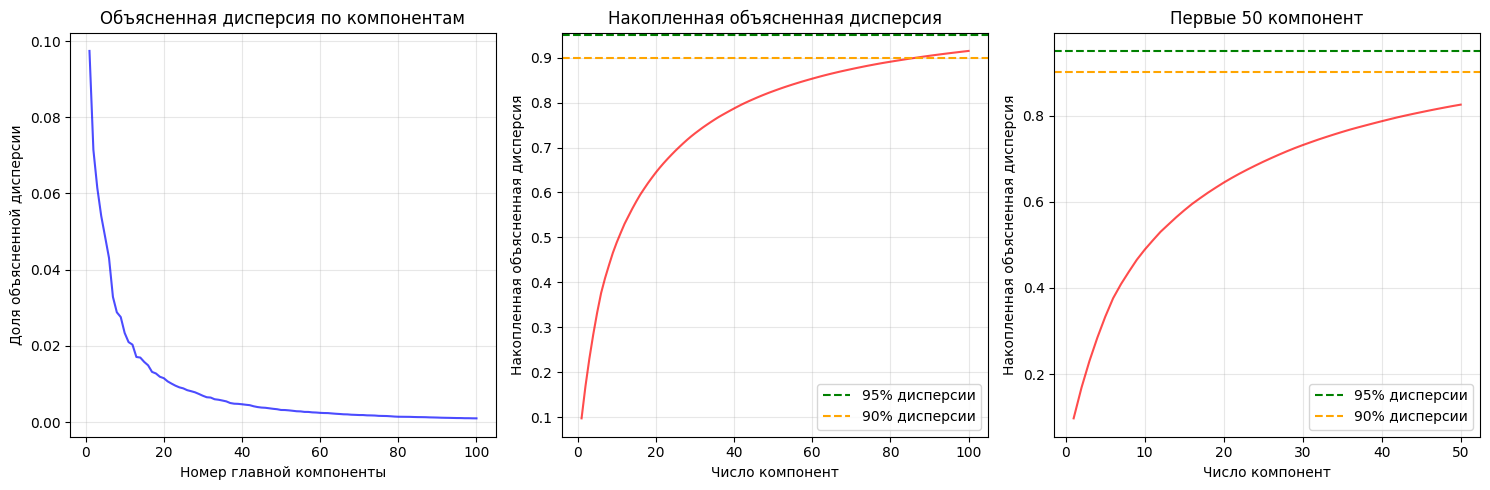


Анализ объясненной дисперсии:
Первые   2 компонент: 0.169 (16.9%)
Первые   5 компонент: 0.333 (33.3%)
Первые  10 компонент: 0.489 (48.9%)
Первые  15 компонент: 0.580 (58.0%)
Первые  20 компонент: 0.644 (64.4%)
Первые  30 компонент: 0.731 (73.1%)
Первые  50 компонент: 0.825 (82.5%)
Первые 100 компонент: 0.915 (91.5%)


In [6]:
# =============================================================================
# АНАЛИЗ PCA НА ДАННЫХ MNIST
# =============================================================================

print("\n" + "="*50)
print("АНАЛИЗ МЕТОДА ГЛАВНЫХ КОМПОНЕНТ")
print("="*50)

# Применяем PCA ко всем компонентам для анализа
pca_full = my_PCA()
X_train_pca_full = pca_full.fit_transform(X_train)

# График собственных значений (объясненной дисперсии)
plt.figure(figsize=(15, 5))

# График 1: Объясненная дисперсия по компонентам
plt.subplot(1, 3, 1)
plt.plot(range(1, 101), pca_full.explained_variance[:100], 'b-', alpha=0.7)
plt.xlabel('Номер главной компоненты')
plt.ylabel('Доля объясненной дисперсии')
plt.title('Объясненная дисперсия по компонентам')
plt.grid(True, alpha=0.3)

# График 2: Накопленная объясненная дисперсия
plt.subplot(1, 3, 2)
plt.plot(range(1, 101), pca_full.cumulative_variance[:100], 'r-', alpha=0.7)
plt.axhline(y=0.95, color='g', linestyle='--', label='95% дисперсии')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% дисперсии')
plt.xlabel('Число компонент')
plt.ylabel('Накопленная объясненная дисперсия')
plt.title('Накопленная объясненная дисперсия')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Увеличение для первых 50 компонент
plt.subplot(1, 3, 3)
plt.plot(range(1, 51), pca_full.cumulative_variance[:50], 'r-', alpha=0.7)
plt.axhline(y=0.95, color='g', linestyle='--', label='95% дисперсии')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% дисперсии')
plt.xlabel('Число компонент')
plt.ylabel('Накопленная объясненная дисперсия')
plt.title('Первые 50 компонент')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ покрытия дисперсии
print("\nАнализ объясненной дисперсии:")
for n_comp in [2, 5, 10, 15, 20, 30, 50, 100]:
    var_explained = pca_full.cumulative_variance[n_comp-1]
    print(f"Первые {n_comp:3d} компонент: {var_explained:.3f} ({var_explained*100:.1f}%)")

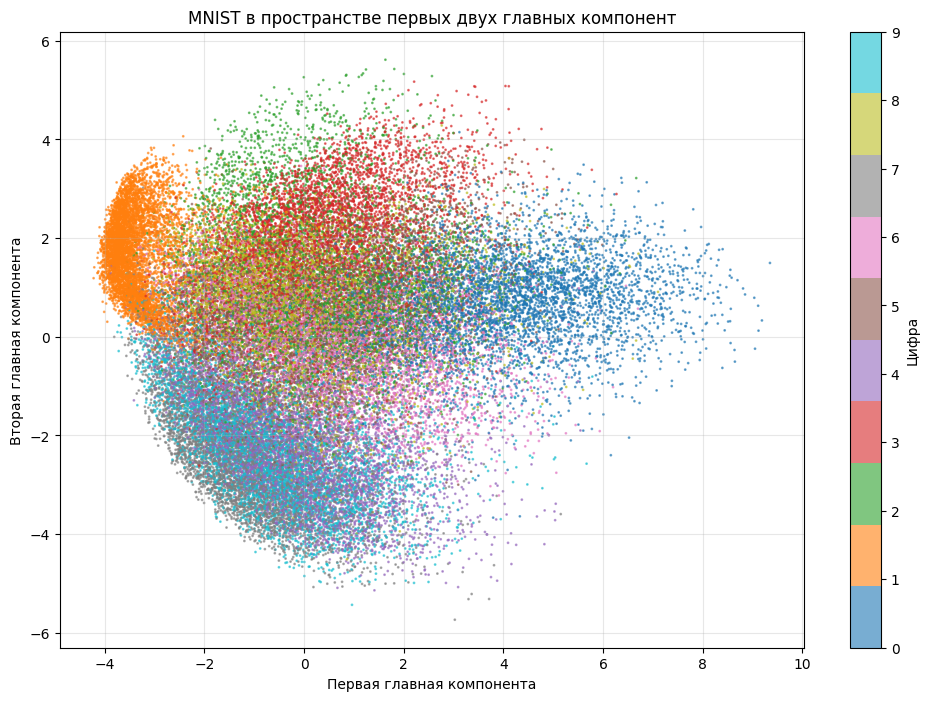

In [7]:
# =============================================================================
# ВИЗУАЛИЗАЦИЯ ДАННЫХ В ПРОСТРАНСТВЕ PCA
# =============================================================================

# Применяем PCA с 2 компонентами для визуализации
pca_2d = my_PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train)

# Визуализация в 2D
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, 
                     cmap='tab10', alpha=0.6, s=1)
plt.colorbar(scatter, label='Цифра')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('MNIST в пространстве первых двух главных компонент')
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# =============================================================================
# ТЕСТИРОВАНИЕ kNN НА ИСХОДНЫХ ДАННЫХ
# =============================================================================

print("\n" + "="*50)
print("ТЕСТИРОВАНИЕ kNN НА ИСХОДНЫХ ДАННЫХ")
print("="*50)

# Используем подвыборку для ускорения вычислений
sample_size = 5000
X_train_small = X_train[:sample_size]
y_train_small = y_train[:sample_size]
X_val_small = X_val[:1000]
y_val_small = y_val[:1000]

# Тестируем kNN на исходных данных
knn_original = my_kNN(n_neighbors=5)
knn_original.fit(X_train_small, y_train_small)

# Предсказания на валидационной выборке
y_pred_original = knn_original.predict(X_val_small)
accuracy_original = accuracy_score(y_val_small, y_pred_original)

print(f"Точность kNN на исходных данных: {accuracy_original:.4f}")



ТЕСТИРОВАНИЕ kNN НА ИСХОДНЫХ ДАННЫХ
Точность kNN на исходных данных: 0.9270


In [9]:
# =============================================================================
# ОПТИМИЗАЦИЯ kNN С ИСПОЛЬЗОВАНИЕМ PCA
# =============================================================================

print("\n" + "="*50)
print("ОПТИМИЗАЦИЯ kNN С ИСПОЛЬЗОВАНИЕМ PCA")
print("="*50)

# Параметры для поиска
n_components_list = [2, 5, 10, 15, 20, 30, 50, 100]
n_neighbors_list = [1, 3, 5, 7, 9, 11]

best_accuracy = 0
best_params = {}

results = []

print("Поиск оптимальных параметров...")
print("Компоненты | Соседи | Точность")
print("-" * 30)

for n_comp in n_components_list:
    # Применяем PCA
    pca = my_PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train_small)
    X_val_pca = pca.transform(X_val_small)
    
    for n_neighbors in n_neighbors_list:
        # Обучаем kNN
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train_small)
        
        # Предсказания и оценка точности
        y_pred = knn.predict(X_val_pca)
        accuracy = accuracy_score(y_val_small, y_pred)
        
        results.append((n_comp, n_neighbors, accuracy))
        
        print(f"{n_comp:10d} | {n_neighbors:7d} | {accuracy:.4f}")
        
        # Сохраняем лучшие параметры
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'n_components': n_comp, 'n_neighbors': n_neighbors}

print(f"\nЛучшая точность: {best_accuracy:.4f}")
print(f"Лучшие параметры: {best_params}")



ОПТИМИЗАЦИЯ kNN С ИСПОЛЬЗОВАНИЕМ PCA
Поиск оптимальных параметров...
Компоненты | Соседи | Точность
------------------------------
         2 |       1 | 0.4000
         2 |       3 | 0.4030
         2 |       5 | 0.4050
         2 |       7 | 0.4160
         2 |       9 | 0.4310
         2 |      11 | 0.4260
         5 |       1 | 0.6970
         5 |       3 | 0.7160
         5 |       5 | 0.7380
         5 |       7 | 0.7370
         5 |       9 | 0.7440
         5 |      11 | 0.7560
        10 |       1 | 0.8820
        10 |       3 | 0.8980
        10 |       5 | 0.9080
        10 |       7 | 0.9060
        10 |       9 | 0.9000
        10 |      11 | 0.9000
        15 |       1 | 0.9180
        15 |       3 | 0.9230
        15 |       5 | 0.9260
        15 |       7 | 0.9220
        15 |       9 | 0.9250
        15 |      11 | 0.9200
        20 |       1 | 0.9360
        20 |       3 | 0.9410
        20 |       5 | 0.9410
        20 |       7 | 0.9450
        20 |       9 | 0.944

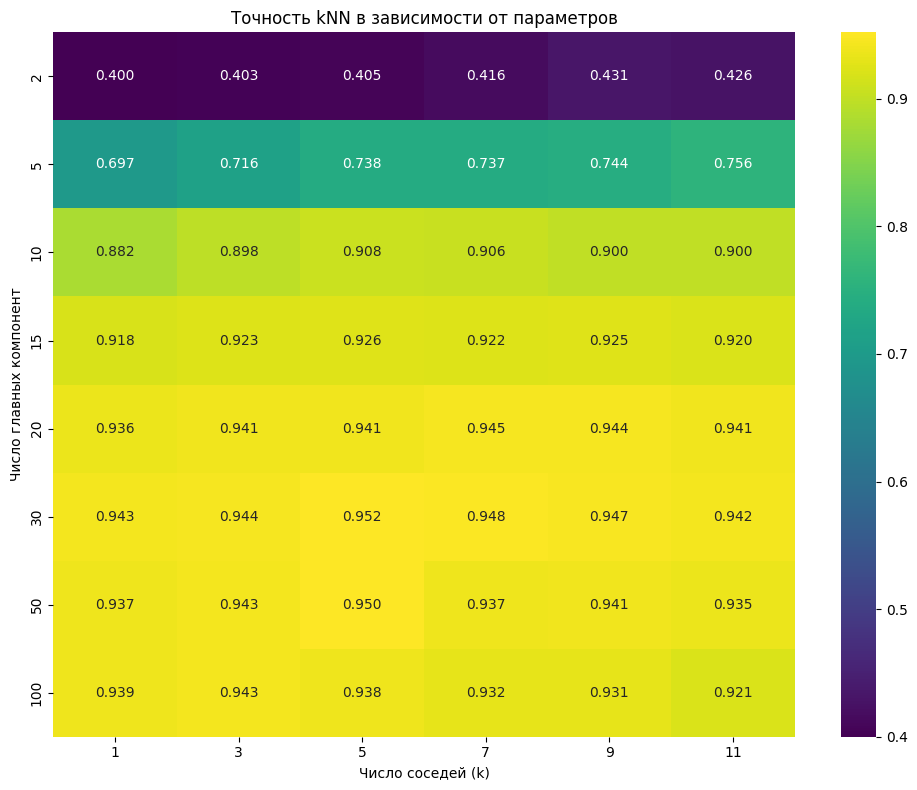

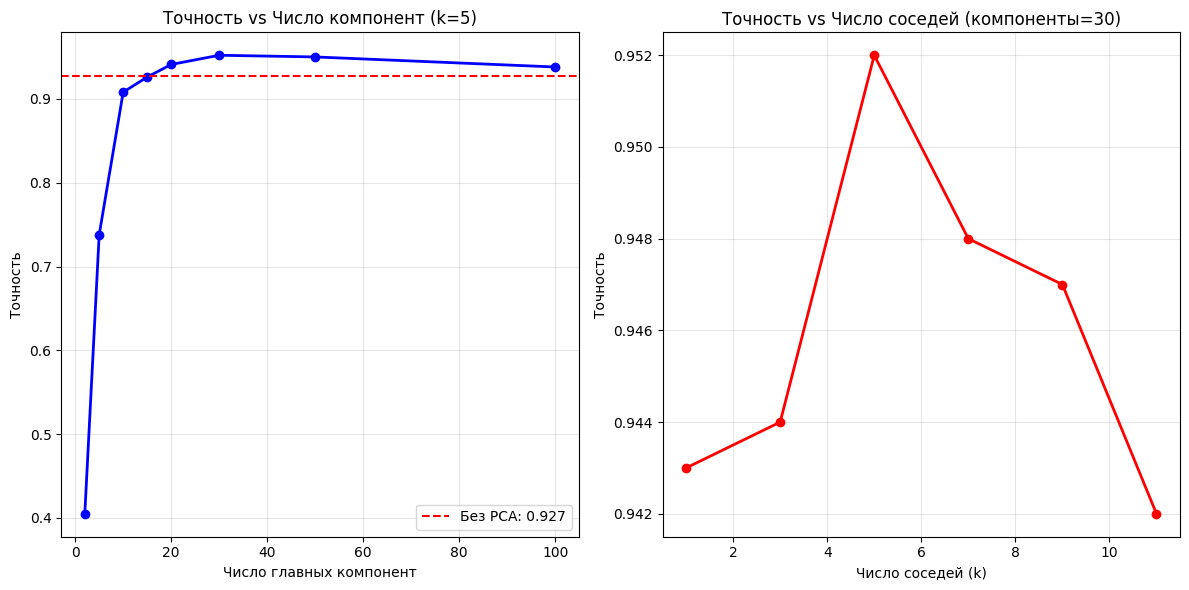

In [10]:
# =============================================================================
# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОПТИМИЗАЦИИ
# =============================================================================

# Преобразуем результаты в матрицу для heatmap
accuracy_matrix = np.zeros((len(n_components_list), len(n_neighbors_list)))
for i, n_comp in enumerate(n_components_list):
    for j, n_neighbors in enumerate(n_neighbors_list):
        for result in results:
            if result[0] == n_comp and result[1] == n_neighbors:
                accuracy_matrix[i, j] = result[2]

# Heatmap точности
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_matrix, 
            xticklabels=n_neighbors_list,
            yticklabels=n_components_list,
            annot=True, fmt='.3f', cmap='viridis')
plt.xlabel('Число соседей (k)')
plt.ylabel('Число главных компонент')
plt.title('Точность kNN в зависимости от параметров')
plt.tight_layout()
plt.show()

# График зависимости точности от числа компонент
plt.figure(figsize=(12, 6))

# Для фиксированного числа соседей (лучшего)
best_k = best_params['n_neighbors']
accuracies_by_components = []

for n_comp in n_components_list:
    accuracy = next((acc for comp, k, acc in results 
                    if comp == n_comp and k == best_k), 0)
    accuracies_by_components.append(accuracy)

plt.subplot(1, 2, 1)
plt.plot(n_components_list, accuracies_by_components, 'bo-', linewidth=2)
plt.axhline(y=accuracy_original, color='r', linestyle='--', 
           label=f'Без PCA: {accuracy_original:.3f}')
plt.xlabel('Число главных компонент')
plt.ylabel('Точность')
plt.title(f'Точность vs Число компонент (k={best_k})')
plt.legend()
plt.grid(True, alpha=0.3)

# График зависимости точности от числа соседей
plt.subplot(1, 2, 2)
best_n_comp = best_params['n_components']
accuracies_by_neighbors = []

for n_neighbors in n_neighbors_list:
    accuracy = next((acc for comp, k, acc in results 
                    if comp == best_n_comp and k == n_neighbors), 0)
    accuracies_by_neighbors.append(accuracy)

plt.plot(n_neighbors_list, accuracies_by_neighbors, 'ro-', linewidth=2)
plt.xlabel('Число соседей (k)')
plt.ylabel('Точность')
plt.title(f'Точность vs Число соседей (компоненты={best_n_comp})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# =============================================================================
# ФИНАЛЬНОЕ ТЕСТИРОВАНИЕ НА ТЕСТОВОЙ ВЫБОРКЕ
# =============================================================================

print("\n" + "="*50)
print("ФИНАЛЬНОЕ ТЕСТИРОВАНИЕ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*50)

# Используем лучшие параметры на всей обучающей выборке
print("Обучение финальной модели...")

# Применяем PCA с лучшим числом компонент
pca_final = my_PCA(n_components=best_params['n_components'])
X_train_final = pca_final.fit_transform(X_train)
X_test_final = pca_final.transform(X_test)

# Обучаем kNN с лучшим числом соседей
knn_final = my_kNN(n_neighbors=best_params['n_neighbors'])
knn_final.fit(X_train_final, y_train)

# Предсказания на тестовой выборке
print("Предсказание на тестовой выборке...")
y_pred_final = knn_final.predict(X_test_final)
accuracy_final = accuracy_score(y_test, y_pred_final)

print(f"Финальная точность на тестовой выборке: {accuracy_final:.4f}")



ФИНАЛЬНОЕ ТЕСТИРОВАНИЕ НА ТЕСТОВОЙ ВЫБОРКЕ
Обучение финальной модели...
Предсказание на тестовой выборке...
Финальная точность на тестовой выборке: 0.9753



ВЫВОДЫ И АНАЛИЗ

1. АНАЛИЗ PCA:
   - Первые 2 компоненты объясняют 0.169 дисперсии
   - Первые 15 компонент объясняют 0.580 дисперсии
   - Первые 50 компонент объясняют 0.825 дисперсии

2. СРАВНЕНИЕ МОДЕЛЕЙ:
   - kNN на исходных данных: 0.9270
   - kNN + PCA (оптимизированный): 0.9753
   - Улучшение за счет PCA: +0.0483

3. ПРАКТИЧЕСКИЕ ПРЕИМУЩЕСТВА PCA:
   - Сокращение размерности: 784 -> 30
   - Сокращение на 96.2%
   - Ускорение вычислений kNN
   - Уменьшение требования к памяти

4. ЛИНЕЙНАЯ РАЗДЕЛИМОСТЬ:
   - Визуализация в 2D показывает частичную линейную разделимость
   - Некоторые цифры (0, 1) хорошо отделимы, другие смешиваются
   - Для полного разделения требуется больше компонент

Визуализация главных компонент...


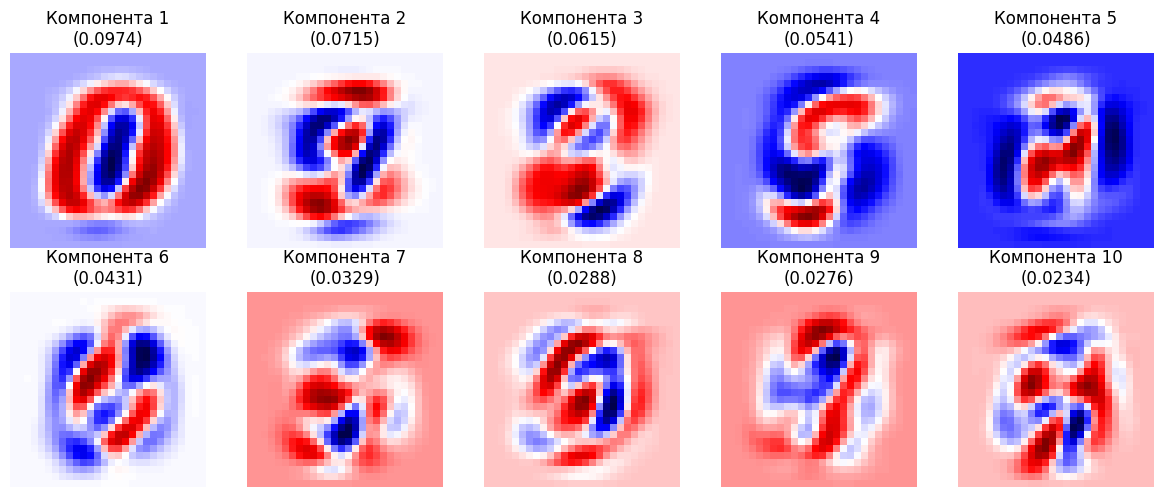

In [12]:
# =============================================================================
# ВЫВОДЫ И АНАЛИЗ
# =============================================================================

print("\n" + "="*50)
print("ВЫВОДЫ И АНАЛИЗ")
print("="*50)

print("\n1. АНАЛИЗ PCA:")
print(f"   - Первые 2 компоненты объясняют {pca_full.cumulative_variance[1]:.3f} дисперсии")
print(f"   - Первые 15 компонент объясняют {pca_full.cumulative_variance[14]:.3f} дисперсии")
print(f"   - Первые 50 компонент объясняют {pca_full.cumulative_variance[49]:.3f} дисперсии")

print("\n2. СРАВНЕНИЕ МОДЕЛЕЙ:")
print(f"   - kNN на исходных данных: {accuracy_original:.4f}")
print(f"   - kNN + PCA (оптимизированный): {accuracy_final:.4f}")

improvement = accuracy_final - accuracy_original
if improvement > 0:
    print(f"   - Улучшение за счет PCA: +{improvement:.4f}")
else:
    print(f"   - Потеря точности: {improvement:.4f}")

print("\n3. ПРАКТИЧЕСКИЕ ПРЕИМУЩЕСТВА PCA:")
print(f"   - Сокращение размерности: 784 -> {best_params['n_components']}")
reduction_ratio = (1 - best_params['n_components'] / 784) * 100
print(f"   - Сокращение на {reduction_ratio:.1f}%")
print("   - Ускорение вычислений kNN")
print("   - Уменьшение требования к памяти")

print("\n4. ЛИНЕЙНАЯ РАЗДЕЛИМОСТЬ:")
print("   - Визуализация в 2D показывает частичную линейную разделимость")
print("   - Некоторые цифры (0, 1) хорошо отделимы, другие смешиваются")
print("   - Для полного разделения требуется больше компонент")

# Визуализация главных компонент
print("\nВизуализация главных компонент...")
def plot_principal_components(pca, n_components=10):
    """Визуализация первых главных компонент как изображений"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    
    for i in range(min(n_components, 10)):
        component_image = pca.components[:, i].reshape(28, 28)
        axes[i].imshow(component_image, cmap='seismic')
        axes[i].set_title(f'Компонента {i+1}\n({pca.explained_variance[i]:.4f})')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_principal_components(pca_full)